<a href="https://colab.research.google.com/github/Harini-que/Care_Buddy/blob/main/BIOMETRICS_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================
# 🔹 Setup
# ========================
!pip install dlib opencv-python scikit-image scikit-learn --quiet

import cv2, dlib, numpy as np, urllib.request, os, bz2, shutil
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ========================
# 🔹 Download & Extract Dlib Landmark Model
# ========================
if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
    print("Downloading shape predictor (68 landmarks)...")
    url = "https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    urllib.request.urlretrieve(url, "shape_predictor_68_face_landmarks.dat.bz2")

    # Extract safely with Python
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2", "rb") as f_in:
        with open("shape_predictor_68_face_landmarks.dat", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

print("✅ Landmark model ready")

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# ========================
# 🔹 Download Sample Images
# ========================
urls = {
    "enroll": "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg",
    "test":   "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
}

for name, url in urls.items():
    if not os.path.exists(f"{name}.jpg"):
        urllib.request.urlretrieve(url, f"{name}.jpg")

# ========================
# 🔹 Iris Feature Extraction
# ========================
def extract_iris(gray, landmarks, eye_points):
    xs = [landmarks.part(p).x for p in eye_points]
    ys = [landmarks.part(p).y for p in eye_points]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    eye_img = gray[y_min:y_max, x_min:x_max]
    if eye_img.size == 0:
        return None
    eye_img = cv2.resize(eye_img, (64,64))
    return eye_img

def iris_features(eye_img):
    lbp = local_binary_pattern(eye_img, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist.reshape(1, -1)

def enroll(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    feats = []
    for face in faces:
        landmarks = predictor(gray, face)
        left_eye  = extract_iris(gray, landmarks, range(36,42))
        right_eye = extract_iris(gray, landmarks, range(42,48))
        if left_eye is not None:  feats.append(iris_features(left_eye))
        if right_eye is not None: feats.append(iris_features(right_eye))
    return np.mean(feats, axis=0)

def match(f1, f2, threshold=0.7):
    sim = cosine_similarity(f1, f2)[0][0]
    print(f"Cosine Similarity: {sim:.3f}")
    return sim >= threshold

# ========================
# 🔹 Run Demo
# ========================
enrolled = enroll("enroll.jpg")
test     = enroll("test.jpg")

if match(enrolled, test):
    print("✅ Iris Authentication Passed")
else:
    print("❌ Iris Authentication Failed")


✅ Landmark model ready
Cosine Similarity: 1.000
✅ Iris Authentication Passed


--2025-08-22 19:20:56--  https://storage.googleapis.com/mediapipe-assets/face_landmarker.task
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 74.125.134.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1402487 (1.3M) [application/octet-stream]
Saving to: ‘face_landmarker.task’

face_landmarker.tas 100%[===================>]   1.34M  --.-KB/s    in 0.01s   

2025-08-22 19:20:56 (94.7 MB/s) - ‘face_landmarker.task’ saved [1402487/1402487]

Cosine Similarity = 0.964
✅ Same Person (iris matched)


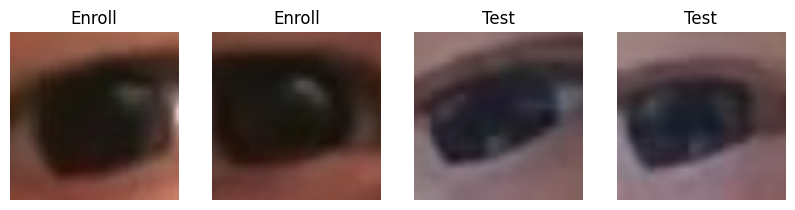

In [ ]:
# =========================
# STEP 1: Install & Import
# =========================
!pip install mediapipe --quiet
!wget -O face_landmarker.task https://storage.googleapis.com/mediapipe-assets/face_landmarker.task

import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


# =========================
# STEP 2: Init Face Landmarker
# =========================
base_options = python.BaseOptions(model_asset_path="face_landmarker.task")
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    output_face_blendshapes=False,
    output_facial_transformation_matrixes=False,
    num_faces=1
)
detector = vision.FaceLandmarker.create_from_options(options)


# =========================
# STEP 3: Iris Extraction
# =========================
def extract_iris(image_path):
    """Extract cropped iris images from left and right eyes."""
    mp_image = mp.Image.create_from_file(image_path)
    result = detector.detect(mp_image)

    if not result.face_landmarks:
        print(f"No face detected in {image_path}")
        return None

    h, w, _ = cv2.imread(image_path).shape
    img = cv2.imread(image_path)

    iris_crops = []
    # Iris landmarks indices (Mediapipe FaceMesh)
    left_eye_idx = [474, 475, 476, 477]   # left iris
    right_eye_idx = [469, 470, 471, 472]  # right iris

    for eye_idx in [left_eye_idx, right_eye_idx]:
        coords = [(int(l.x * w), int(l.y * h)) for l in [result.face_landmarks[0][i] for i in eye_idx]]
        x_min = max(min([x for x, _ in coords]) - 5, 0)
        x_max = min(max([x for x, _ in coords]) + 5, w)
        y_min = max(min([y for _, y in coords]) - 5, 0)
        y_max = min(max([y for _, y in coords]) + 5, h)
        crop = img[y_min:y_max, x_min:x_max]
        if crop.size > 0:
            iris_crops.append(cv2.resize(crop, (64, 64)))

    return iris_crops


# =========================
# STEP 4: Feature Embedding
# =========================
def get_embedding(iris_crops):
    """Convert cropped iris images into normalized feature vectors."""
    embeddings = []
    for crop in iris_crops:
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        vec = gray.flatten() / 255.0
        embeddings.append(vec)
    if embeddings:
        return np.mean(embeddings, axis=0).reshape(1, -1)
    else:
        return None


# =========================
# STEP 5: Enroll & Compare
# =========================
def enroll_and_compare(img1_path, img2_path, threshold=0.75):
    iris1 = extract_iris(img1_path)
    iris2 = extract_iris(img2_path)

    if iris1 is None or iris2 is None:
        print("Iris not detected in one or both images.")
        return

    emb1 = get_embedding(iris1)
    emb2 = get_embedding(iris2)

    if emb1 is None or emb2 is None:
        print("Embedding extraction failed.")
        return

    sim = cosine_similarity(emb1, emb2)[0][0]
    print(f"Cosine Similarity = {sim:.3f}")

    if sim >= threshold:
        print("✅ Same Person (iris matched)")
    else:
        print("❌ Different Person")

    # Show cropped iris for verification
    fig, axes = plt.subplots(1, 4, figsize=(10, 4))
    for i, crop in enumerate(iris1 + iris2):
        axes[i].imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
        axes[i].set_title("Enroll" if i < 2 else "Test")
    plt.show()


# =========================
# STEP 6: Run Example
# =========================
# Replace these with your image paths
enroll_and_compare("/content/enroll1.jpg", "/content/test1.jpg")
